# Introduction

<div class="alert alert-block alert-warning">
<font color=black><br>

**What?** Quantile regression with TF many quantiles with a single training call

**Reference [code]:** https://github.com/strongio/quantile-regression-tensorflow/blob/master/Quantile%20Loss.ipynb<br>    

<br></font>
</div>

# Quantile regression with one training call

<div class="alert alert-block alert-info">
<font color=black><br>

- There should be a way to compute the quantile in one go without having to re-run the model twice (lower & upper models).
- This does seems to be an easy thing to do in KERAS as exaplined in the article.
- However you can do it in **Tensor Flow** as shown in here: https://github.com/strongio/quantile-regression-tensorflow/blob/master/Quantile%20Loss.ipynb

<br></font>
</div>

# Import modules

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = 17, 8
rcParams['font.size'] = 20

# https://stackoverflow.com/questions/55142951/tensorflow-2-0-attributeerror-module-tensorflow-has-no-attribute-session
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Import the dataset

<div class="alert alert-block alert-info">
<font color=black><br>

- Standardise the inputs and outputs so that it is easier to train.
- So apparently the guy is standardisining the input for regression, something that I was wondering about but I have not found something to back it up.

<br></font>
</div>

In [3]:
mcycle = pd.read_csv('../DATASETS/motorcycleAccident.txt', delimiter = '\t')

In [4]:
mcycle.times = (mcycle.times - mcycle.times.mean())/mcycle.times.std()
mcycle.accel = (mcycle.accel - mcycle.accel.mean())/mcycle.accel.std()

In [5]:
# Reshape to input format for network
times = np.expand_dims(mcycle.times.values, 1)
accel = np.expand_dims(mcycle.accel.values, 1)

# Build the model

In [13]:
# Create network
class q_model:
    def __init__(self,
                 sess,
                 quantiles,
                 in_shape=1,
                 out_shape=1,
                 batch_size=32):

        self.sess = sess

        self.quantiles = quantiles
        self.num_quantiles = len(quantiles)

        self.in_shape = in_shape
        self.out_shape = out_shape
        self.batch_size = batch_size

        self.outputs = []
        self.losses = []
        self.loss_history = []

        self.build_model()

    def build_model(self, scope='q_model', reuse=tf.AUTO_REUSE):
        with tf.variable_scope(scope, reuse=reuse) as scope:
            self.x = tf.placeholder(tf.float32, shape=(None, self.in_shape))
            self.y = tf.placeholder(tf.float32, shape=(None, self.out_shape))

            self.layer0 = tf.layers.dense(self.x,
                                          units=32,
                                          activation=tf.nn.relu)
            self.layer1 = tf.layers.dense(self.layer0,
                                          units=32,
                                          activation=tf.nn.relu)

            # Create outputs and losses for all quantiles
            for i in range(self.num_quantiles):
                q = self.quantiles[i]

                # Get output layers
                output = tf.layers.dense(
                    self.layer1, 1, name="{}_q{}".format(i, int(q*100)))
                self.outputs.append(output)

                # Create losses

                error = tf.subtract(self.y, output)
                loss = tf.reduce_mean(tf.maximum(
                    q*error, (q-1)*error), axis=-1)

                self.losses.append(loss)

            # Create combined loss
            self.combined_loss = tf.reduce_mean(tf.add_n(self.losses))
            self.train_step = tf.train.AdamOptimizer().minimize(self.combined_loss)

    def fit(self, x, y, epochs=100):
        for epoch in range(epochs):
            epoch_losses = []
            for idx in range(0, x.shape[0], self.batch_size):
                batch_x = x[idx: min(idx + self.batch_size, x.shape[0]), :]
                batch_y = y[idx: min(idx + self.batch_size, y.shape[0]), :]

                feed_dict = {self.x: batch_x,
                             self.y: batch_y}

                _, c_loss = self.sess.run(
                    [self.train_step, self.combined_loss], feed_dict)
                epoch_losses.append(c_loss)

            epoch_loss = np.mean(epoch_losses)
            self.loss_history.append(epoch_loss)
            if epoch % 100 == 0:
                print("Epoch {}: {}".format(epoch, epoch_loss))

    def predict(self, x):
        # Run model to get outputs
        feed_dict = {self.x: x}
        predictions = sess.run(self.outputs, feed_dict)

        return predictions

In [ ]:
# Initialize session
sess = tf.Session()

# Instantiate model
quantiles = [.1, .5, .9]
model = q_model(sess, quantiles, batch_size=32)

# Initialize all variables
init_op = tf.global_variables_initializer()
sess.run(init_op)

In [15]:
# Run training
epochs = 2000
model.fit(times, accel, epochs)

Epoch 0: 1.2225145101547241
Epoch 100: 0.5915203094482422
Epoch 200: 0.4263633191585541
Epoch 300: 0.37727558612823486
Epoch 400: 0.3430660665035248
Epoch 500: 0.31162917613983154
Epoch 600: 0.2936154901981354
Epoch 700: 0.27809178829193115
Epoch 800: 0.2727813422679901
Epoch 900: 0.26371854543685913
Epoch 1000: 0.25920388102531433
Epoch 1100: 0.2531242072582245
Epoch 1200: 0.24986350536346436
Epoch 1300: 0.24811096489429474
Epoch 1400: 0.24611449241638184
Epoch 1500: 0.24855400621891022
Epoch 1600: 0.24708330631256104
Epoch 1700: 0.24385561048984528
Epoch 1800: 0.2417490929365158
Epoch 1900: 0.24625642597675323


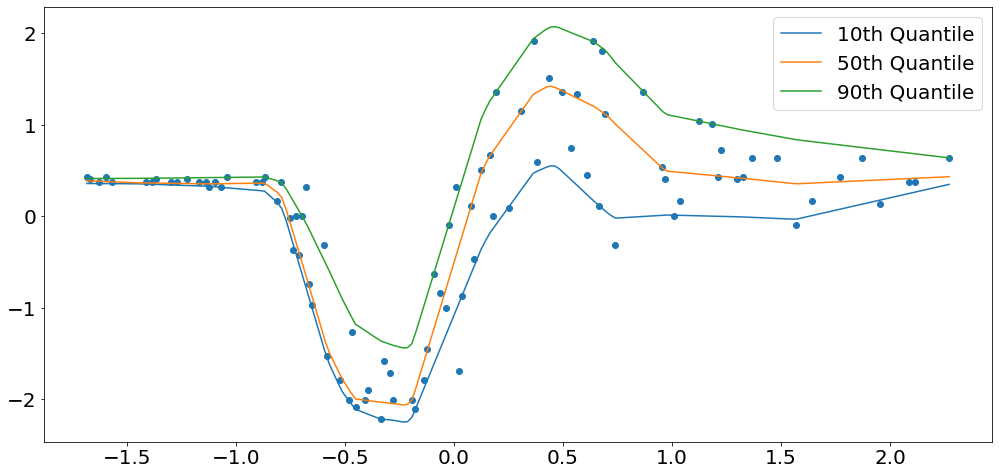

In [20]:
# Generate the range of data we'd like to predict
test_times = np.expand_dims(np.linspace(times.min(),times.max(),200), 1)
predictions = model.predict(test_times)

plt.scatter(times, accel)
for i, prediction in enumerate(predictions):
    plt.plot(test_times, prediction, label='{}th Quantile'.format(int(model.quantiles[i]*100)))
    
plt.legend()
plt.show()

# Conclusion

<div class="alert alert-block alert-danger">
<font color=black><br>

- TF over Keras if you want to save time. 

<br></font>
</div>